# HW 9-1
## Abby Baskind
## 31 October 2023

2.	 Make a function to solve Ci with the input of the initial values of Ci and other parameters (e.g., Δt (time steps) and number of time steps), so that you can easily use that for different input values. 

3.	Make the timestep much shorter (1 day) and much longer (50 years) and plot the results.
a.	What happens? Why?
b.	How can we choose a sensible value? 

4.	Submit the codes and report with plots and answers to the questions.


In [2]:
%cd /Users/akbaskind/Documents/Python Scripts/OCG577

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# Import K's code for calculating the coefficients of the carb system
import calc_coeffs as co2
import H_poly as hpoly
import H_poly2 as hpoly2
from importlib import reload
import warnings
# warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

/Users/akbaskind/Documents/Python Scripts/OCG577


# 1. Set the initial concentrations C1 = 0.1, C2 = 0.1, C3 = 1.0 and run the model and plot the results.
## a. What do you expect the final state to look like? Why? 
In the final state, all the concentrations should be the same because after sufficient time the water will mix to be homogenous. 

## b. How long does it take to reach a steady state? Plot the results that shows steady state is reached.
~4 Gyr. It takes so long because the volumetric flow between boxes is much smaller than the volume of the boxes.

## c. What sets the timescale to reach a steady state?
The volume of the boxes, the flow between boxes

In [148]:
t = np.arange(0,1000,100)
for i in range(len(t)):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [149]:
def threeboxmodel(time, dt, initial_concentrations, **kwargs):
    
    import numpy as np
    
    if len(initial_concentrations) != 3:
        raise ValueError('Length of initial_concentrations does not match number of boxes (3).')
    else:
        C1_0 = initial_concentrations[0]
        C2_0 = initial_concentrations[1]
        C3_0 = initial_concentrations[2]
    
    # Keyword arguments can change the size of the boxes
    if 'dx' in kwargs:
        dx = kwargs.get('dx')
        dx = np.asarray(dx)
    else:
        dx = np.array([17e6, 17e6, 17e6])   # longitude (m)
        
    if 'dy' in kwargs:
        dy = kwargs.get('dy')
        dy = np.asarray(dy)
    else:
        dy = np.array([8e6, 8e6, 16e6])     # latitude (m)
        
    if 'dz' in kwargs:
        dz = kwargs.get('dz')
        dz = np.asarray(dz)
    else:
        dz = np.array([100, 100, 5000])     # depth (m)
      
    # Calculate Volume
    V = dx * dy * dz                    # volume of each box (m^3)
    print(V)
    
    # Time array
    TIME = np.arange(0,time,dt)         # duration [years]

    # Keyword arguments can change the transfer
    if 'phi' in kwargs:
        phi = kwargs.get('phi')
    else:
        phi = 20e6         # m^3/s
        
    if 'k13' in kwargs:
        k13 = kwargs.get('k13')
    else:
        k13 = 1e6          # m^3/s
        
    if 'k23' in kwargs:
        k23 = kwargs.get('k23')
    else:
        k23 = 1e6          # m^3/s
        
    if 'k12' in kwargs:
        k12 = kwargs.get('k12')
    else:
        k12 = 1e6          # m^3/s
        
    if 'k31' in kwargs:
        k31 = kwargs.get('k31')
    else:
        k31 = k13          # m^3/s
        
    if 'k32' in kwargs:
        k32 = kwargs.get('k32')
    else:
        k32 = k23          # m^3/s
        
    if 'k21' in kwargs:
        k21 = kwargs.get('k21')
    else:
        k21 = k12          # m^3/s
    
    # Arrays to store concentrations over time
    C1 = np.zeros(len(TIME))
    C2 = np.zeros(len(TIME))
    C3 = np.zeros(len(TIME))

    for k in range(len(TIME)):
        # At time step 0, set flux to 0
        # if k == 0:
        #     dC1dt = 0
        #     dC2dt = 0
        #     dC3dt = 0
        # # Calculate rate of change
        # else:
            # dC1dt = (1/V[0])*(phi*(C3[t-1]-C1[t-1]) + k31*(C3[t-1]-C1[t-1]) + k21*(C2[t-1]-C1[t-1]))
            # dC2dt = (1/V[1])*(phi*(C1[t-1]-C2[t-1]) + k12*(C1[t-1]-C2[t-1]) + k32*(C3[t-1]-C2[t-1]))
            # dC3dt = (1/V[2])*(phi*(C2[t-1]-C3[t-1]) + k23*(C2[t-1]-C3[t-1]) + k13*(C1[t-1]-C3[t-1]))
    
        dC1dt = (1/V[0])*(phi*(C3_0-C1_0) + k31*(C3_0-C1_0) + k21*(C2_0-C1_0))
        dC2dt = (1/V[1])*(phi*(C1_0-C2_0) + k12*(C1_0-C2_0) + k32*(C3_0-C2_0))
        dC3dt = (1/V[2])*(phi*(C2_0-C3_0) + k23*(C2_0-C3_0) + k13*(C1_0-C3_0))
        # Calculate concentration at time t
        C1[k] = C1_0 + dC1dt * dt
        C2[k] = C2_0 + dC2dt * dt
        C3[k] = C3_0 + dC3dt * dt
    
        # Set initial (aka C(t-1)) to latest solution
        C1_0 = C1[k]
        C2_0 = C2[k]
        C3_0 = C3[k]
        
    TOTAL = C1 * V[0] + C2 * V[1] + C3 * V[2]
        
    data = {
        'Box 1 Concentration': C1,
        'Box 2 Concentration': C2,
        'Box 3 Concentration': C3,
        'Box 1 Volume': V[0],
        'Box 2 Volume': V[1],
        'Box 3 Volume': V[2],
        'Box 1 Total': C1 * V[0],
        'Box 2 Total': C2 * V[1],
        'Box 3 Total': C3 * V[2],
        'TOTAL': TOTAL,
        't': TIME
        }
    return data

## Control Run

[1.36e+16 1.36e+16 1.36e+18]


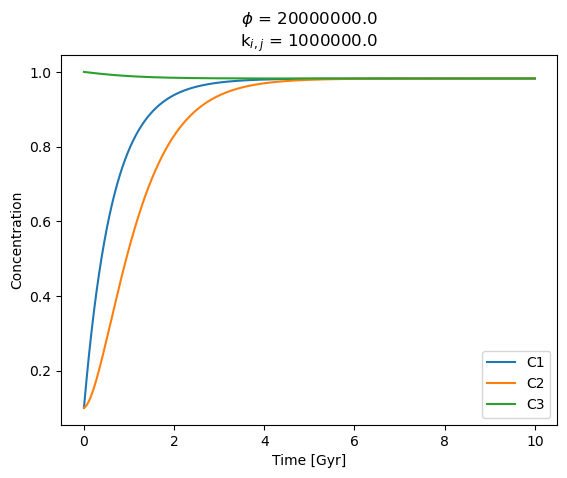

In [137]:
results = threeboxmodel(10e9,100000,[0.1,0.1,1])
plt.plot(results['t']/1e9, results['Box 1 Concentration'], label = 'C1')
plt.plot(results['t']/1e9, results['Box 2 Concentration'], label = 'C2')
plt.plot(results['t']/1e9, results['Box 3 Concentration'], label = 'C3')
plt.xlabel('Time [Gyr]')
plt.ylabel('Concentration')
title = '$\phi$ = ' + str(20e6) + '\nk$_{i,j}$ = ' + str(1e6)
plt.title(title)
plt.legend()

## Increase transfer coefficients
by an order of magnitude

Larger transfer decreases time to reach steady state.

[1.36e+16 1.36e+16 1.36e+18]


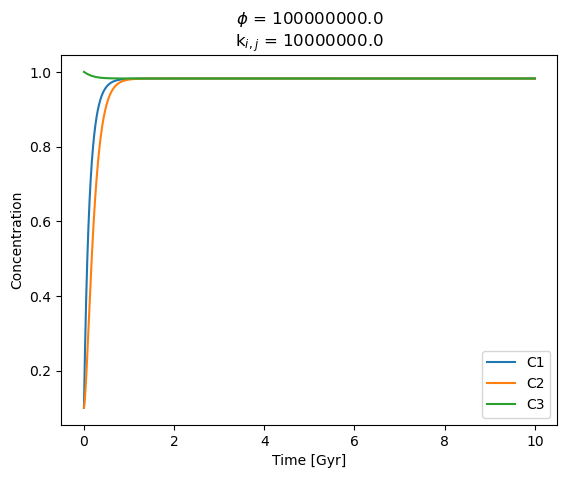

In [138]:
results = threeboxmodel(10e9,100000,[0.1,0.1,1],
                       phi = 100e6, k12 = 10e6, k13 = 10e6, k23 = 10e6)
plt.plot(results['t']/1e9, results['Box 1 Concentration'], label = 'C1')
plt.plot(results['t']/1e9, results['Box 2 Concentration'], label = 'C2')
plt.plot(results['t']/1e9, results['Box 3 Concentration'], label = 'C3')
plt.xlabel('Time [Gyr]')
plt.ylabel('Concentration')
title = '$\phi$ = ' + str(100e6) + '\nk$_{i,j}$ = ' + str(10e6)
plt.title(title)
plt.legend()

## Decrease volume of boxes

Decreasing volume of boxes decreases time to reach steady state.

[4.9e+15 4.9e+15 4.9e+16]


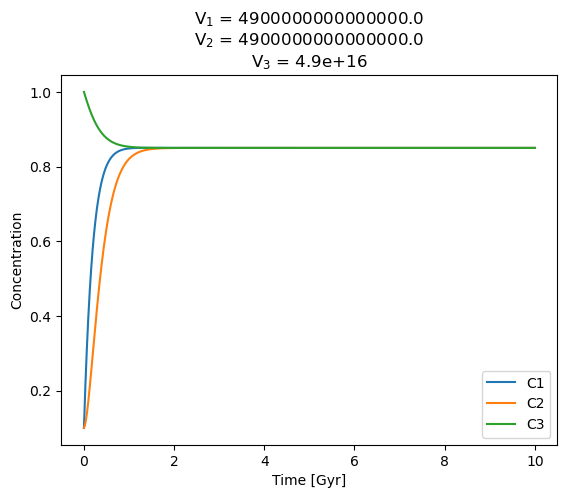

In [139]:
results = threeboxmodel(10e9,100000,[0.1,0.1,1],
                       dx = [7e6, 7e6, 7e6], dy = [7e6, 7e6, 7e6], dz = [100, 100, 1000])
plt.plot(results['t']/1e9, results['Box 1 Concentration'], label = 'C1')
plt.plot(results['t']/1e9, results['Box 2 Concentration'], label = 'C2')
plt.plot(results['t']/1e9, results['Box 3 Concentration'], label = 'C3')
plt.xlabel('Time [Gyr]')
plt.ylabel('Concentration')
title = 'V$_{1}$ = ' + str(results['Box 1 Volume']) + '\nV$_{2}$ = ' + str(results['Box 2 Volume']) + '\nV$_{3}$ = ' + str(results['Box 3 Volume'])
plt.title(title)
plt.legend()


## Different initial concentrations
It appears changing the initial concentrations doesn't significiantly change the time to reach steady state.

[1.36e+16 1.36e+16 1.36e+18]
[1.36e+16 1.36e+16 1.36e+18]


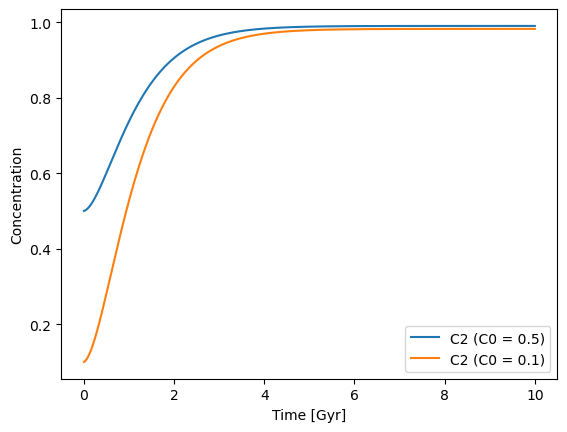

In [151]:
results = threeboxmodel(10e9,100000,[0.5,0.5,1])
# plt.plot(results['t']/1e9, results['Box 1 Concentration'], label = 'C1 (C0 = 0.5)')
plt.plot(results['t']/1e9, results['Box 2 Concentration'], label = 'C2 (C0 = 0.5)')
# plt.plot(results['t']/1e9, results['Box 3 Concentration'], label = 'C3 (C0 = 0.1)')
plt.xlabel('Time [Gyr]')
plt.ylabel('Concentration')
# title = 'V$_{1}$ = ' + str(results['Box 1 Volume']) + '\nV$_{2}$ = ' + str(results['Box 2 Volume']) + '\nV$_{3}$ = ' + str(results['Box 3 Volume'])
# plt.title(title)


results = threeboxmodel(10e9,100000,[0.1,0.1,1])
# plt.plot(results['t']/1e9, results['Box 1 Concentration'], label = 'C1 (C0 = 0.1)')
plt.plot(results['t']/1e9, results['Box 2 Concentration'], label = 'C2 (C0 = 0.1)')
# plt.plot(results['t']/1e9, results['Box 3 Concentration'], label = 'C3 (C0 = 1)')
plt.legend()


## Different time steps
I am going to make the volume of the boxes much much smaller so i can make really short time steps without having a bajillion time steps to a steady state at a billion years.

[1.7e+15 1.7e+15 1.7e+17]
---Run time =  0.02180790901184082 seconds ---


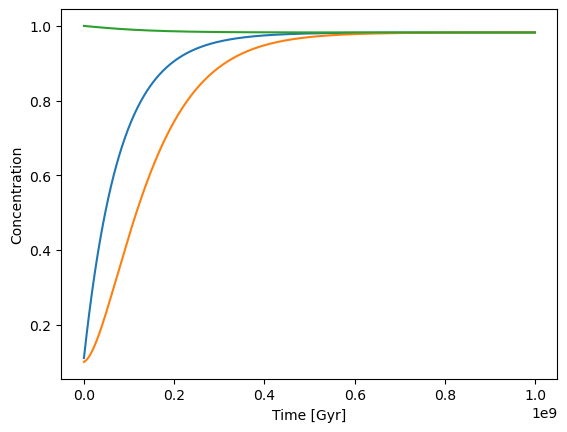

In [163]:
import time
start_time = time.time()

results = threeboxmodel(1e9,1e6,[0.1,0.1,1], 
                        dy = [1e7,1e7,1e7],dz = [10,10,1000])
plt.plot(results['t'], results['Box 1 Concentration'], label = 'C1')
plt.plot(results['t'], results['Box 2 Concentration'], label = 'C2')
plt.plot(results['t'], results['Box 3 Concentration'], label = 'C3')
plt.xlabel('Time [Gyr]')
plt.ylabel('Concentration')
# title = 'V$_{1}$ = ' + str(results['Box 1 Volume']) + '\nV$_{2}$ = ' + str(results['Box 2 Volume']) + '\nV$_{3}$ = ' + str(results['Box 3 Volume'])
# plt.title(title)
print("---Run time =  %s seconds ---" % (time.time() - start_time))




Decreasing the time step increases the run time

[1.7e+15 1.7e+15 1.7e+17]
---Run time = 2.9569201469421387 seconds ---


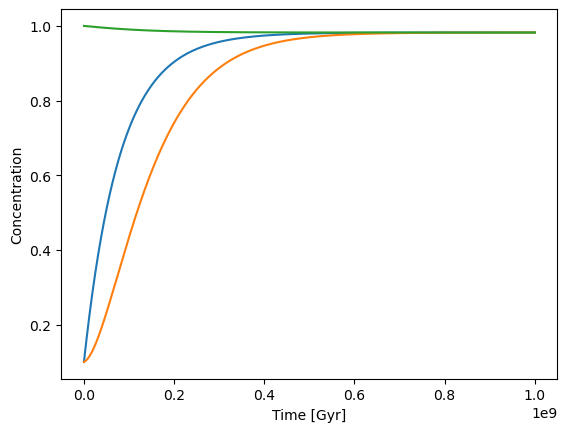

In [164]:
import time
start_time = time.time()

results = threeboxmodel(1e9,1e3,[0.1,0.1,1], 
                        dy = [1e7,1e7,1e7],dz = [10,10,1000])
plt.plot(results['t'], results['Box 1 Concentration'], label = 'C1')
plt.plot(results['t'], results['Box 2 Concentration'], label = 'C2')
plt.plot(results['t'], results['Box 3 Concentration'], label = 'C3')
plt.xlabel('Time [Gyr]')
plt.ylabel('Concentration')
# title = 'V$_{1}$ = ' + str(results['Box 1 Volume']) + '\nV$_{2}$ = ' + str(results['Box 2 Volume']) + '\nV$_{3}$ = ' + str(results['Box 3 Volume'])
# plt.title(title)
print("---Run time = %s seconds ---" % (time.time() - start_time))



